# Ensemble Learning and Random Forests
In many cases you will find that this aggregated answer is better than an expert’s answer. This is called the wisdom of the crowd. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method.

As an example of an Ensemble method, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you obtain the predictions of all the individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a Random Forest, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.


## Voting Classifiers
Suppose you have trained a few classifiers, each one achieving about 80% accuracy. 

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a ***hard voting*** classifier. 

This voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a ***weak learner*** (meaning it does only slightly better than random guessing), the ensemble can still be a ***strong learner*** (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on this mystery. Suppose you have a slightly biased coin that has a 51% chance of coming up heads and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%. The more you toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to the ***law of large numbers***: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%).

The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers.

In [132]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [35]:
# make data
X_train, y_train = make_moons(n_samples=10000, noise=0.25)
X_test, y_test = make_moons(n_samples=1000, noise=0.25)

In [36]:
# make classifiers
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [37]:
# checking each classifier score
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.853
RandomForestClassifier 0.935
SVC 0.935
VotingClassifier 0.936


If all classifiers are able to estimate class probabilities (i.e., they all have a pre dict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace voting="hard" with voting="soft" and ensure that all classifiers can estimate class probabilities. This is not the case for the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method). It may increase the accuracy. Let's try it out.

In [38]:
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

# checking each classifier score
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.853
RandomForestClassifier 0.934
SVC 0.935
VotingClassifier 0.936


## Bagging and Pasting
One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor and train them on different random subsets of the training set. When sampling is performed with replacement, this method is called bagging (short for bootstrap aggregating). When sampling is performed without replacement, it is called pasting.

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression. 

### Bagging and Pasting in Scikit-Learn
Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClas sifier class (or BaggingRegressor for regression). The following code trains an ensemble of 500 Decision Tree classifiers:5 each is trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set bootstrap=False). The n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores):

In [39]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, 
    n_jobs=-1
)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [41]:
y_pred = bag_clf.predict(X_test)
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

BaggingClassifier 0.932


Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting; but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s variance is reduced. Overall, bagging often results in better models, which explains why it is generally preferred.

### Out of Bag Evaluation
With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a BaggingClassifier samples m training instances with replacement (bootstrap=True), where m is the size of the training set. Those instances which are not sampled are called ***out-of-bag (oob) instances***, and may be different for exery predictor.

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an automatic oob evaluation after training. The following code demonstrates this. The resulting evaluation score is available through the oob_score_ variable:

In [42]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500,
    bootstrap=True, 
    n_jobs=-1, 
    oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9396

In [43]:
# this accuracy score will be around same that of previous cell
y_pred = bag_clf.predict(X_test)
print(f"Accuracy Score - {accuracy_score(y_test, y_pred)}")

Accuracy Score - 0.935


The oob decision function for each training instance is also available through the ***oob_decision_function_*** variable. In this case (since the base estimator has a ***predict_proba()*** method), the decision function returns the class probabilities for each training instance.

In [44]:
bag_clf.oob_decision_function_

array([[0.88709677, 0.11290323],
       [1.        , 0.        ],
       [0.81325301, 0.18674699],
       ...,
       [0.13756614, 0.86243386],
       [0.4591195 , 0.5408805 ],
       [1.        , 0.        ]])

## Random Forest
Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with max_samples set to the size of the training set. Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier class, which is more convenient and optimized for Decision Trees. The following code uses all available CPU cores to train a Random Forest classifier with 500 trees (each limited to maximum 16 nodes):

In [45]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [46]:
y_pred_rf = rnd_clf.predict(X_test)
print(f"Accuracy Score - {accuracy_score(y_test, y_pred_rf)}")

Accuracy Score - 0.941


The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. The algorithm results in greater tree diversity, which (again) trades a higher bias for a lower variance, generally yielding an overall better model. The following BaggingClassifier is roughly equivalent to the previous RandomForestClassifier:
```Python
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, 
    max_samples=1.0, 
    bootstrap=True, 
    n_jobs=-1
)
```

### Extra-Trees
When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).

A forest of such extremely random trees is called an Extremely Randomized Trees ensemble (or Extra-Trees for short). Once again, this technique trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

You can create an Extra-Trees classifier using Scikit-Learn’s ExtraTreesClassifier class. Its API is identical to the RandomForestClassifier class. Similarly, the Extra TreesRegressor class has the same API as the RandomForestRegressor class.

NOTE: It is hard to tell in advance whether a RandomForestClassifier will perform better or worse than an ExtraTreesClassifier. Generally, the only way to know is to try both and compare them using cross-validation (tuning the hyperparameters using grid search).

### Feature Importance
Another great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.

Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. You can access the result using the feature_importances_ variable. For example, the following code trains a RandomForestClassifier on the iris dataset and outputs each feature’s importance.

In [47]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10461223801878682
sepal width (cm) 0.025190125233975603
petal length (cm) 0.4351317341136877
petal width (cm) 0.43506590263355


## Boosting
Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are AdaBoost (short for Adaptive Boosting) and Gradient Boosting.

### Ada Boost
One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predic‐ tors focusing more and more on the hard cases. This is the technique used by AdaBoost.

For example, when training an AdaBoost classifier, the algorithm first trains a base classifier (such as a Decision Tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on.

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

Let’s take a closer look at the AdaBoost algorithm. Each instance weight $w^{(i)}$ is initially set to $1/m$. A first predictor is trained, and its weighted error rate $r_1$ is computed on the training set.

***Weighted error rate of the $j^{th}$ predictor*** <br>
$
r_j = \frac{\underset{\hat{y}_j^{(i)} \neq y_j^{(i)}}{\sum_{i=1}^m w^{(i)}} }{\sum_{i=1}^m w^{(i)}}
$

where $\hat{y}_j^{(i)}$ is the jth predictor’s prediction for the ith instance.

The predictor’s weight αj is then computed, where η is the learning rate hyperparameter (defaults to 1). The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.

***Predictor weight*** <br>
$
\alpha_j = \eta log\frac{1 - r_j}{r_j}
$

Next, the AdaBoost algorithm updates the instance weights, which boosts the weights of the misclassified instances.

***Weight update rule*** <br>
for i = 1, 2, ..., m <br>
$
w^{(i)} = \left\{ \begin{array}{rl}
w^{(i)} &\mbox{ if $\hat{y}_j^{(i)} = y_j^{(i)}$} \\
w^{(i)}\exp{(\alpha_j)} &\mbox{ if $\hat{y}_j^{(i)} \neq y_j^{(i)}$}
       \end{array} \right.
$

Then all the instance weights are normalized.

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes.

Scikit-Learn uses a multiclass version of AdaBoost called ***SAMME (which stands for Stagewise Additive Modeling using a Multiclass Exponential loss function)***. When there are just two classes, SAMME is equivalent to AdaBoost. If the predictors can estimate class probabilities (i.e., if they have a predict_proba() method), Scikit-Learn can use a variant of **SAMME** called **SAMME.R** (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better.

The following code trains an AdaBoost classifier based on 200 Decision Stumps using Scikit-Learn’s AdaBoostClassifier class (as you might expect, there is also an Ada BoostRegressor class). A Decision Stump is a Decision Tree with max_depth=1 — in other words, a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the AdaBoostClassifier class:

In [48]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm='SAMME.R',
    learning_rate=0.5,
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

### Gradient Boost
Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

Let’s go through a simple regression example, using Decision Trees as the base predictors (of course, Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT). First, let’s fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training set):

In [117]:
# data prep
import numpy as np

X = np.linspace(-50, 50, 500)
noise = np.random.normal(0, 100, size=X.shape)
y = X**2 + noise

In [118]:
# print data samples
print(X[:5])
print(noise[:5])
print(y[:5])

[-50.         -49.7995992  -49.5991984  -49.3987976  -49.19839679]
[  9.53421027 142.43804235  67.54777529   8.82506354  79.99082845]
[2509.53421027 2622.43812267 2527.6282569  2449.06626739 2500.47307551]


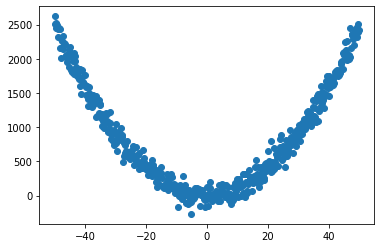

In [119]:
# plot data
import matplotlib.pyplot as plt
plt.scatter(X, y)

In [120]:
# split the data
from sklearn.model_selection import train_test_split

X, X_new, y, y_new = train_test_split(X, y, test_size=0.33)

In [121]:
# reshape data, according to input requirement
X = X.reshape((-1, 1))
X_new = X_new.reshape((-1, 1))

# Sanity check
print(f"X.shape - {X.shape}")
print(f"y.shape - {y.shape}")
print(f"X_new.shape - {X_new.shape}")
print(f"y_new.shape - {y_new.shape}")

X.shape - (335, 1)
y.shape - (335,)
X_new.shape - (165, 1)
y_new.shape - (165,)


In [122]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [123]:
# train a second DecisionTreeRegressor on the residual errors made by the first predictor
y2 = y - tree_reg1.predict(X)

tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [124]:
# train a third DecisionTreeRegressor on the residual errors made by the first predictor
y3 = y2 - tree_reg1.predict(X)

tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [128]:
# Now we have an ensemble containing three trees. It can make predictions on a new
# instance simply by adding up the predictions of all the trees:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(f"MSE - {mean_squared_error(y_new, y_pred)}")
print(f"MAE - {mean_absolute_error(y_new, y_pred)}")

MSE - 1018833.5413112247
MAE - 797.3878906435757


A simpler way to train GBRT ensembles is to use Scikit-Learn’s GradientBoostingRe gressor class. Much like the RandomForestRegressor class, it has hyperparameters to control the growth of Decision Trees (e.g., max_depth, min_samples_leaf), as well as hyperparameters to control the ensemble training, such as the number of trees (n_estimators). The following code creates the same ensemble as the previous one:

In [129]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

The **learning_rate** hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the train‐ ing set, but the predictions will usually generalize better. This is a regularization tech‐ nique called ***shrinkage***.

GBRT may underfit if it does not have sufficient number of trees and overfit if it has too many trees.In order to find the optimal number of trees, you can use early stopping . A simple way to implement this is to use the staged_predict() method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:

In [135]:
# n_estimators: the number of boosting stages to perform
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X, y)

# get errors, and find minimum error among all these stages
errors = [mean_squared_error(y_new, y_pred) for y_pred in gbrt.staged_predict(X_new)]
print(f"Errors:")
for ind, error in enumerate(errors):
    print(f"Index - {ind}\MSE - {error}")
bst_n_estimators = np.argmin(errors) + 1
print(f"bst_n_estimators - {bst_n_estimators}")

Errors:
Index - 0\MSE - 448867.4334867611
Index - 1\MSE - 384619.7518546116
Index - 2\MSE - 334145.7594560882
Index - 3\MSE - 286958.82265370135
Index - 4\MSE - 250235.35830303511
Index - 5\MSE - 220221.20697357357
Index - 6\MSE - 193365.78861617885
Index - 7\MSE - 168590.6675658507
Index - 8\MSE - 150879.2263217608
Index - 9\MSE - 135264.56440844337
Index - 10\MSE - 119175.68064056354
Index - 11\MSE - 106234.11718813228
Index - 12\MSE - 95622.310251313
Index - 13\MSE - 87729.39712116508
Index - 14\MSE - 78095.67462133266
Index - 15\MSE - 70786.01236492129
Index - 16\MSE - 63510.88010654962
Index - 17\MSE - 57134.84631575513
Index - 18\MSE - 52737.766809555666
Index - 19\MSE - 47441.29514894984
Index - 20\MSE - 44273.80570921537
Index - 21\MSE - 40409.53729169354
Index - 22\MSE - 36624.24087362093
Index - 23\MSE - 34363.47596787056
Index - 24\MSE - 31485.526783547888
Index - 25\MSE - 29993.9510101917
Index - 26\MSE - 28580.666566756143
Index - 27\MSE - 26192.830042261947
Index - 28\MSE

In [136]:
# retrain model with n_estimators=bst_n_estimators
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=90,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [137]:
# test on Val data
preds = gbrt_best.predict(X_new)
print(f"MSE - {mean_squared_error(y_new, preds)}")
print(f"MAE - {mean_absolute_error(y_new, preds)}")

MSE - 12652.511693098495
MAE - 86.61742379276654


It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). You can do so by setting ***warm_start=True***, which makes ScikitLearn keep existing trees when the fit() method is called, allowing incremental training. The following code stops training when the validation error does not improve for five iterations in a row:

In [140]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X, y)
    y_pred = gbrt.predict(X_new)
    val_error = mean_squared_error(y_new, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping

print(n_estimators)            

73


The GradientBoostingRegressor class also supports a subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree. For example, if ***subsample=0.25***, then each tree is trained on 25% of the training instances, selected randomly. As you can probably guess by now, this technique trades a higher bias for a lower variance. It also speeds up training considerably. This is called ***Stochastic Gradient Boosting***.

It is worth noting that an optimized implementation of Gradient Boosting is available in the popular Python library XGBoost, which stands for Extreme Gradient Boosting. In fact, XGBoost is often an important component of the winning entries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s:

In [141]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X, y)
y_pred = xgb_reg.predict(X_new)

[16:23:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [142]:
# xgb with early stopping
xgb_reg.fit(X, y,
            eval_set=[(X_new, y_new)], 
            early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_new)

[16:24:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:987.399
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:900.499
[2]	validation_0-rmse:819.934
[3]	validation_0-rmse:747.232
[4]	validation_0-rmse:682.676
[5]	validation_0-rmse:626.7
[6]	validation_0-rmse:572.599
[7]	validation_0-rmse:524.309
[8]	validation_0-rmse:480.362
[9]	validation_0-rmse:441.104
[10]	validation_0-rmse:406.228
[11]	validation_0-rmse:374.701
[12]	validation_0-rmse:344.708
[13]	validation_0-rmse:318.556
[14]	validation_0-rmse:294.42
[15]	validation_0-rmse:272.614
[16]	validation_0-rmse:254.466
[17]	validation_0-rmse:238.011
[18]	validation_0-rmse:222.802
[19]	validation_0-rmse:209.171
[20]	validation_0-rmse:197.565
[21]	validation_0-rmse:186.608
[22]	validation_0-rmse:177.867
[23]	validation_0-rmse:169.665
[24]	validation_0-rmse:162.785
[25]	validation_0-rmse:156.302
[26]	validation_

In [143]:
print(f"MSE - {mean_squared_error(y_new, y_pred)}")
print(f"MAE - {mean_absolute_error(y_new, y_pred)}")

MSE - 13584.731835216935
MAE - 88.91328956321627
